# Математическая статистика, ДЗ 12

### Куйбида Всеволод Иванович БПМИ214

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f, t, norm
import pandas as pd
import seaborn as sns

In [2]:
sns.set(style='darkgrid', palette='deep')

P.S. Требуемые для ДЗ файлы должны лежать в директории ./data/

# Задание 1

### Задача **1**.

#### Класс линейной регрессии:

In [3]:
class LinearRegression:
    def __init__(self, fit_intercept=True, degree=1):
        self.fit_intercept = fit_intercept
        self.degree = degree
        self._params = None

    def fit(self, X, y):
        if (len(X.shape) == 1):
            X_poly = np.vander(X, self.degree + 1, increasing=True)
        else:
            X_poly = np.hstack([np.ones((X.shape[0], 1)), X])
        if (self.fit_intercept is False):
            X_poly = X_poly[:, 1:]
        self._params = np.linalg.pinv(X_poly) @ y

        # np.pinv устойчиво генерирует "псевдорешение" - совпадает с нашей формулой нахождения оценки МНК

    def predict(self, X):
        if (len(X.shape) == 1):
            X_poly = np.vander(X, self.degree + 1, increasing=True)
        else:
            X_poly = np.hstack([np.ones((X.shape[0], 1)), X])
        if (self.fit_intercept is False):
            X_poly = X_poly[:, 1:]
        return X_poly @ self._params

#### Загрузим данные:

In [4]:
pts = np.loadtxt("data/data.csv", delimiter=",", dtype=float, skiprows=1, usecols=(1, 2))

In [5]:
print(pts)

[[ 0.          0.52376655]
 [ 0.02020202  0.63387445]
 [ 0.04040404  0.51598294]
 [ 0.06060606  0.55754801]
 [ 0.08080808  0.51257093]
 [ 0.1010101   0.7141333 ]
 [ 0.12121212  0.82102674]
 [ 0.14141414  0.38324838]
 [ 0.16161616  0.75984197]
 [ 0.18181818  0.25307229]
 [ 0.2020202   0.6172289 ]
 [ 0.22222222  0.40867202]
 [ 0.24242424  0.6206625 ]
 [ 0.26262626  0.81791734]
 [ 0.28282828  0.41594049]
 [ 0.3030303   0.60594596]
 [ 0.32323232  0.04828258]
 [ 0.34343434  0.18305001]
 [ 0.36363636  0.1299806 ]
 [ 0.38383838  0.56165927]
 [ 0.4040404   0.66274553]
 [ 0.42424242  0.58738538]
 [ 0.44444444  0.55404085]
 [ 0.46464646  0.67148424]
 [ 0.48484848  0.39031438]
 [ 0.50505051  0.57585768]
 [ 0.52525253  0.39463298]
 [ 0.54545455  0.1860667 ]
 [ 0.56565657  0.49582081]
 [ 0.58585859  0.3407278 ]
 [ 0.60606061  0.39389416]
 [ 0.62626263  0.21574611]
 [ 0.64646465  0.65700263]
 [ 0.66666667 -0.04126689]
 [ 0.68686869  0.23025042]
 [ 0.70707071  0.4847217 ]
 [ 0.72727273  0.25685523]
 

#### Визуализируем на одном графике получившиеся модели линейной регрессии при $p = 1, 2, 3, 5, 10, 25$ при помощи line plot и исходные данные в виде scatter plot:

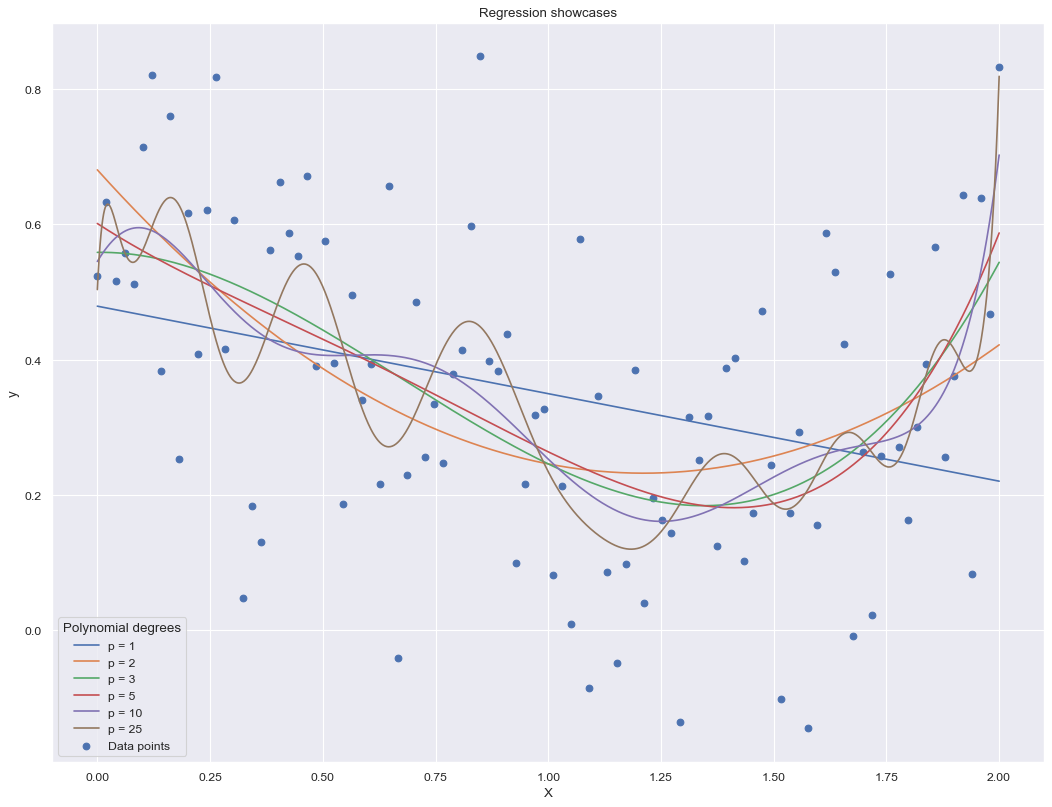

In [6]:
plt.figure(figsize=(16, 12), dpi=80)
X = pts[:, 0]
y = pts[:, 1]
x_min = np.min(pts[:, 0])
x_max = np.max(pts[:, 0])
x_pts = np.linspace(x_min, x_max, 1010)
for p in (1, 2, 3, 5, 10, 25):
    model = LinearRegression(degree=p)
    model.fit(X, y)
    approximation_p = model.predict(x_pts)
    plt.plot(x_pts, approximation_p, label=f"p = {p}")
plt.scatter(pts[:, 0], pts[:, 1], label="Data points")
plt.legend(title="Polynomial degrees")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Regression showcases")
plt.show()

#### Выводы: видим, что чем больше степень многочлена, тем лучше наша регрессия описывает **имеющиеся** данные, не учитывая информации, лежащей под ними (модель переобучилась)

### Задача **2**.

#### Рассмотрим регрессию при p = 25 и проверим гипотезу вида $\theta_k = 0$ для всех $k \geqslant 10$ на уровене значимости 0.05 при условии неизвестной дисперсии:

In [7]:
p = 25
r = 16
n = X.shape[0]
model_25 = LinearRegression(degree=p)
model_10 = LinearRegression(degree=(p - r))
model_25.fit(X, y)
model_10.fit(X, y)
test_statistic = (n - p - 1) * (np.linalg.norm(y - model_10.predict(X)) ** 2 - np.linalg.norm(y - model_25.predict(X)) ** 2) / (r * np.linalg.norm(y - model_25.predict(X)) ** 2)

Значение нашей тестовой статистики:

In [8]:
print(test_statistic)

0.5985607481201233


Посчитаем p-value:

In [9]:
print(f"The p-value is {f.sf(test_statistic, r, n - p)}")

The p-value is 0.8753328872274415


Очевидно, что гипотеза принимается.

#### Выводы: коэффициенты выше 10-й степени не "находят закономерности" в данных, а просто подстраиваются под уменьшение нормы ошибки, как бы запоминая данные

### Задача **3**.

#### Реализуем процедуру выбора степени многочлена $p = 1, ..., 25$ при помощи AIC и найдём оптимальную степень многочлена:

In [10]:
def sigma_sq_estimate(y, y_estimate, p):
    n = y.shape[0]
    return np.linalg.norm(y - y_estimate) ** 2 / (n - p)

The optimal polynomial degree is 3


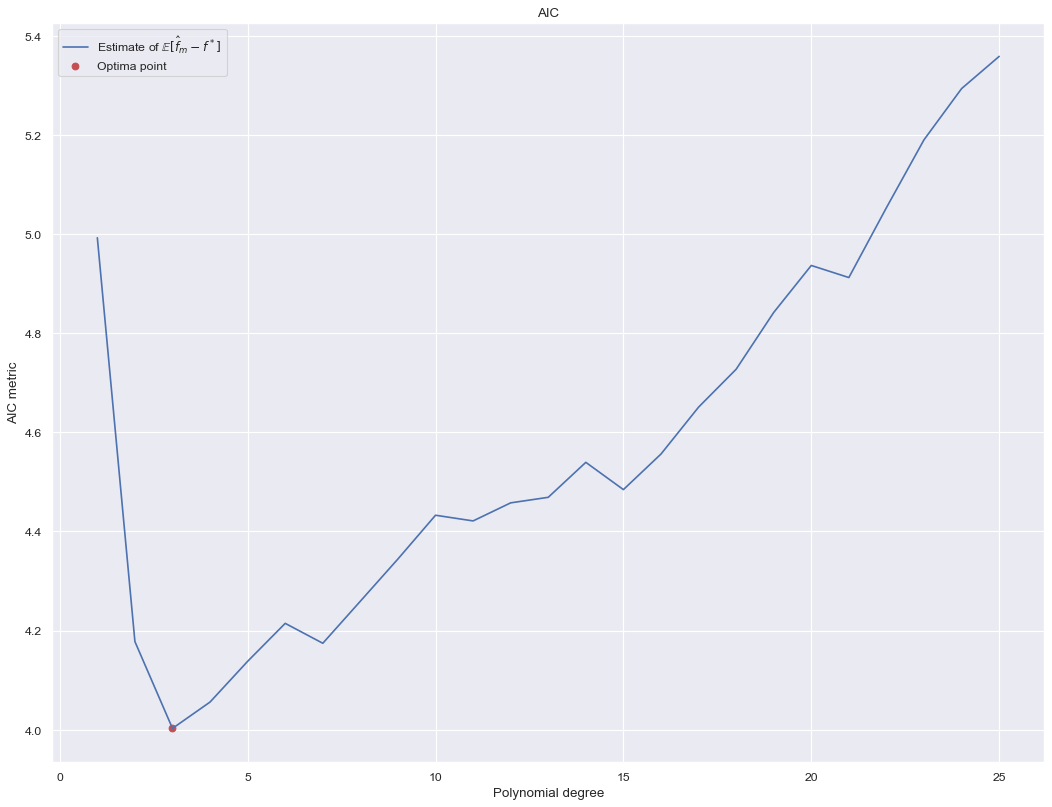

In [11]:
risks = np.zeros((25, ))
plt.figure(figsize=(16, 12), dpi=80)
xs = np.linspace(1, 25, 25)
for p in range(1, 26):
    model_p = LinearRegression(degree=p)
    model_p.fit(X, y)
    y_hat = model_p.predict(X)
    risk_p = np.linalg.norm(y_hat - y) ** 2 + 2 * sigma_sq_estimate(y, y_hat, p + 1) * (p + 1)
    risks[p - 1] = risk_p
p_optimal = np.argmin(risks) + 1
print(f"The optimal polynomial degree is {p_optimal}")
plt.xlabel("Polynomial degree")
plt.ylabel("AIC metric")
plt.title("AIC")
plt.plot(xs, risks, label="Estimate of $\mathbb{E}[\hat{f}_m - f^*]$")
plt.scatter([p_optimal], [risks[p_optimal - 1]], color="r", label="Optima point")
plt.legend()
plt.show()

#### Выводы: скорее всего, функция является многочленом 3-й степени с гауссовским шумом с большой дисперсией (можно видеть, что точки сильно отклоняются от "точного положения", но при этом сильных уклонений нет (хвосты не тяжелые))

# Задание 2

#### Загрузим данные по рекламным объявлениям:

In [12]:
data_ads = np.loadtxt("data/Advertising.csv", delimiter=",", dtype=float, skiprows=1, usecols=(1, 2, 3, 4))
print(data_ads)

[[230.1  37.8  69.2  22.1]
 [ 44.5  39.3  45.1  10.4]
 [ 17.2  45.9  69.3   9.3]
 [151.5  41.3  58.5  18.5]
 [180.8  10.8  58.4  12.9]
 [  8.7  48.9  75.    7.2]
 [ 57.5  32.8  23.5  11.8]
 [120.2  19.6  11.6  13.2]
 [  8.6   2.1   1.    4.8]
 [199.8   2.6  21.2  10.6]
 [ 66.1   5.8  24.2   8.6]
 [214.7  24.    4.   17.4]
 [ 23.8  35.1  65.9   9.2]
 [ 97.5   7.6   7.2   9.7]
 [204.1  32.9  46.   19. ]
 [195.4  47.7  52.9  22.4]
 [ 67.8  36.6 114.   12.5]
 [281.4  39.6  55.8  24.4]
 [ 69.2  20.5  18.3  11.3]
 [147.3  23.9  19.1  14.6]
 [218.4  27.7  53.4  18. ]
 [237.4   5.1  23.5  12.5]
 [ 13.2  15.9  49.6   5.6]
 [228.3  16.9  26.2  15.5]
 [ 62.3  12.6  18.3   9.7]
 [262.9   3.5  19.5  12. ]
 [142.9  29.3  12.6  15. ]
 [240.1  16.7  22.9  15.9]
 [248.8  27.1  22.9  18.9]
 [ 70.6  16.   40.8  10.5]
 [292.9  28.3  43.2  21.4]
 [112.9  17.4  38.6  11.9]
 [ 97.2   1.5  30.    9.6]
 [265.6  20.    0.3  17.4]
 [ 95.7   1.4   7.4   9.5]
 [290.7   4.1   8.5  12.8]
 [266.9  43.8   5.   25.4]
 

In [13]:
tv = data_ads[:, 0]
radio = data_ads[:, 1]
newspaper = data_ads[:, 2]
sales = data_ads[:, 3]
print(tv.shape)

(200,)


### Задача **1.**

#### Построим уравнение линейной регрессии, используя следующую модель:

$$Sales_i = \theta_0^* + TV_i \cdot \theta_1^* + \varepsilon_i$$


In [14]:
model_tv = LinearRegression()
model_tv.fit(tv, sales)

#### Вычислим R^2 для этой модели, проверим гипотезу о значимости коэффициента $\theta_1$ с уровнем значимости 0.05:

In [15]:
def get_r_sq(y, y_hat):
    return 1 - (np.linalg.norm(y - y_hat) ** 2) / (np.linalg.norm(y - np.mean(y)) ** 2)

In [16]:
r_sq = get_r_sq(sales, model_tv.predict(tv))

Коэффициент детерминации:

In [17]:
print(r_sq)

0.611875050850071


Проверка гипотезы:

In [18]:
n = sales.shape[0]
test_statistic = (n - 2) * (np.linalg.norm(sales - np.mean(sales)) ** 2 - np.linalg.norm(sales - model_tv.predict(tv)) ** 2) / (np.linalg.norm(sales - model_tv.predict(tv)) ** 2)

Тестовая статистика:

In [19]:
print(np.sqrt(test_statistic))

17.66762560087554


Значение p-value:

In [20]:
print(t.sf(np.sqrt(test_statistic), n - 2))

7.336948500973589e-43


Отвергаем гипотезу.

#### Визуализируем нашу модель вместе с исходными данными:

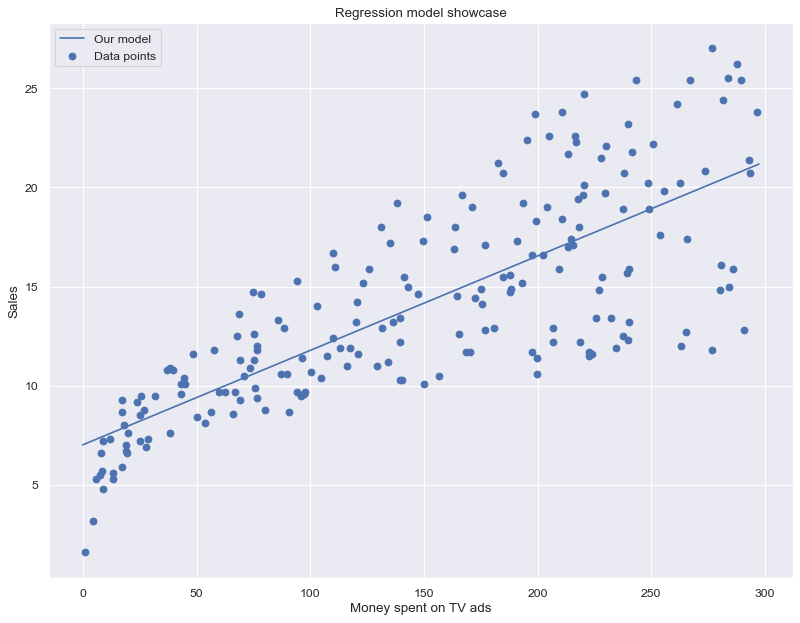

In [21]:
plt.figure(figsize=(12, 9), dpi=80)
x_min = np.min(tv - 1)
x_max = np.max(tv + 1)
x_pts = np.linspace(x_min, x_max, 1010)
approximation_p = model_tv.predict(x_pts)
plt.plot(x_pts, approximation_p, label=f"Our model")
plt.scatter(tv, sales, label="Data points")
plt.xlabel("Money spent on TV ads")
plt.ylabel("Sales")
plt.title("Regression model showcase")
plt.legend()
plt.show()

Видно, что зависимость здесь не совсем линейная.

### Задача **2.**

#### Модифицируем модель, преобразов признаки как
$$\ln{Sales_i} = \theta_0^* + \ln{TV_i} \cdot \theta_1^* + \varepsilon_i$$

In [22]:
model_tv_ln = LinearRegression()
model_tv_ln.fit(np.log(tv), np.log(sales))

#### Посчитаем коэффициент детерминации:

In [23]:
print(get_r_sq(sales, np.exp(model_tv_ln.predict(np.log(tv)))))

0.6099995192519305


#### Проверим гипотезу о том, что $\theta_1^* = 0$, найдя p-value статистики:

In [24]:
n = sales.shape[0]
test_statistic = (n - 2) * (np.linalg.norm(sales - np.mean(sales)) ** 2 - np.linalg.norm(sales - np.exp(model_tv_ln.predict(np.log(tv)))) ** 2) / (np.linalg.norm(sales - np.exp(model_tv_ln.predict(np.log(tv)))) ** 2)
print(t.sf(np.sqrt(test_statistic), n - 2))

1.1842296946542939e-42


Отвергаем гипотезу.

#### Визуализируем новую полученную модель:

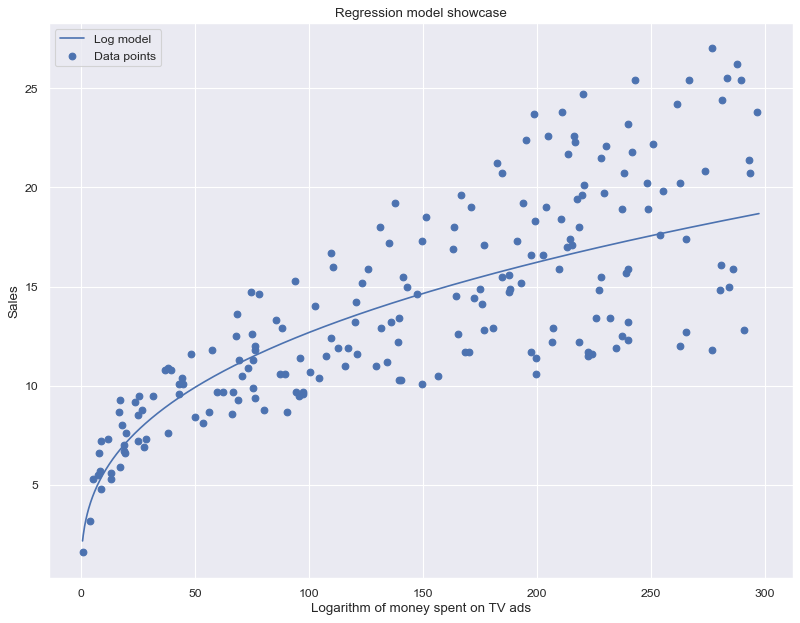

In [25]:
plt.figure(figsize=(12, 9), dpi=80)
x_min = np.min(tv)
x_max = np.max(tv + 1)
x_pts = np.linspace(x_min, x_max, 1010)
approximation_p = np.exp(model_tv_ln.predict(np.log(x_pts)))
plt.plot(x_pts, approximation_p, label=f"Log model")
plt.scatter(tv, sales, label="Data points")
plt.xlabel("Logarithm of money spent on TV ads")
plt.ylabel("Sales")
plt.title("Regression model showcase")
plt.legend()
plt.show()
plt.show()

Несмотря на то, что коэффициент детерминации стал немного меньше, визуально видно, что эта модель лучше описывает данные, нежели линейная

### Задача **3.**

#### Добавим оставшиеся переменные:

$$\ln{Sales_i} = \theta_0^* + \theta_1^* \cdot \ln{TV_i} + \theta_2^* \cdot Radio_i + \theta_3^* \cdot Newspaper_i + \varepsilon_i$$

и обучим новую модель линейной регрессии:

In [26]:
model_ads = LinearRegression()
model_ads.fit(np.vstack([np.log(tv), radio, newspaper]).T, np.log(sales))

#### Вычислим $R^2$:

In [27]:
print(get_r_sq(sales, np.exp(model_ads.predict(np.vstack([np.log(tv), radio, newspaper]).T))))

0.9801374473790292


Видим, что мы очень хорошо "объяснили дисперсию данных", а сама модель стала лучше.

#### Посчитаем 0.95-доверительные интервалы для всех коэффициентов:

тут мы пользуемся тем, что: $\frac{\hat{\theta_j} - \theta_j}{\hat{\sigma}\sqrt{(\Psi \Psi^T)^{-1}_{jj}}} \sim t(n - p)$

In [28]:
ALPHA = 0.05
p = 4
n = sales.shape[0]
quantile = t.ppf((1 + ALPHA) / 2, n - p)
params = model_ads._params
plan = np.vstack([np.log(tv), radio, newspaper]).T
error = np.linalg.norm(sales - np.exp(model_ads.predict(plan)))
plan_inv = np.linalg.inv(np.hstack([np.ones((n, 1)), plan]).T @ np.hstack([np.ones((n, 1)), plan]))
param_names = ["Intercept", "Log TV", "Radio", "Magazines"]
for i in range(4):
    lower_bound = params[i] - (error * np.sqrt(plan_inv[i, i]) * quantile) / np.sqrt(n - p)
    upper_bound = params[i] + (error * np.sqrt(plan_inv[i, i]) * quantile) / np.sqrt(n - p)
    print(f"The {ALPHA}-confidence interval for {param_names[i]} is [{lower_bound}, {upper_bound}]")

The 0.05-confidence interval for Intercept is [0.5645718146706888, 0.5979934483516023]
The 0.05-confidence interval for Log TV is [0.353766926129681, 0.3603347487640686]
The 0.05-confidence interval for Radio is [0.01310190065902299, 0.013577088641600654]
The 0.05-confidence interval for Magazines is [-2.4037930772564898e-05, 0.0003001493864360847]


In [29]:
for (i, j) in zip(param_names, np.reciprocal(model_ads._params)):
    print(f"The inverse {i} coefficient is {j}")

The inverse Intercept coefficient is 1.7203335275996905
The inverse Log TV coefficient is 2.800721620345699
The inverse Radio coefficient is 74.96535859974456
The inverse Magazines coefficient is 7243.451725658489


Видим, что 0.05-доверительный интервал для рекламы в журналах содержит ноль, что говорит о том, что реклама в газетах не даёт вклада в модель. Значит, в неё не нужно вкладываться. Видим, что самый выгодный способ рекламы - реклама по радио: чтобы повысить продажи вдвое (увеличить логарифм продаж на один), то нам требуется потратить ещё порядка $\frac{1}{0.013339494650311822} = 74.96535859974456$ долларов на рекламу на радио, а на телевидении мы должны потратить порядка $exp(2.800721620345699) * 1000 = 16456.51784547416$ долларов (ввиду того, что данные по рекламе на ТВ - в тысячах), про рекламу в журналах вообще нет смысла говорить.

# Задание **3.**

#### Загрузим данные курса (оттуда нам понадобится только стоимость на момент закрытия торгов):

In [30]:
data_xchg = np.loadtxt("data/USDRUB.csv", delimiter=";", dtype=float, skiprows=1, usecols=(7))
p = 2
print(data_xchg)

[108.45    95.75   103.0754 103.     101.0982 106.6625 105.9931  96.7266
 102.2056 101.25   100.9007  95.75    85.      83.4701  81.7081  85.
  82.75    82.25    83.9925  82.115   78.5     79.5     80.25    82.75
  85.3625  81.925   81.875   82.75    82.75    80.375   80.9679  82.25
  80.8626  76.625   76.625   75.025   74.875   73.881   72.7522  70.6
  70.5608  68.2539  65.375   64.075   67.5     68.95    68.75    66.
  65.1145  64.5     63.875 ]


#### Построим оценку параметров методом наименьших квадратов для модели линейной регрессии

$$<CLOSE> = \theta_0 + \theta_1 \cdot \Delta <Date> + \varepsilon, \mathbb{E}[\varepsilon] = 0$$

где $\Delta<Date>$ – это количество дней, которое прошло с 15 марта 2022 года и визуализируем вашу оценку на промежутке от 15 марта 2022 до 15 сентября 2022 в виде line plot и данные в виде scatter plot

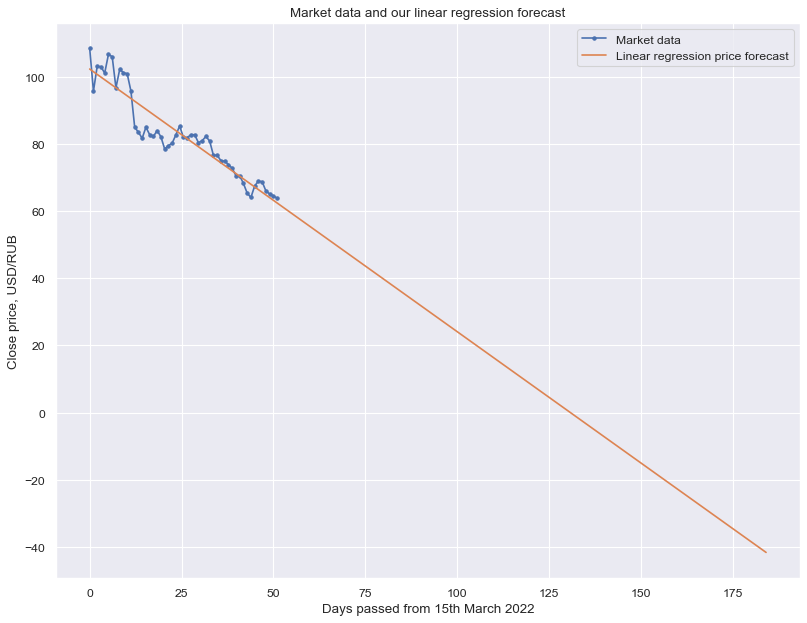

In [31]:
plt.figure(figsize=(12, 9), dpi=80)
plt.title("Market data and our linear regression forecast")
model_xchg = LinearRegression()
model_xchg.fit(np.linspace(0, data_xchg.shape[0], data_xchg.shape[0]), data_xchg)
lin_approx_xchg = model_xchg.predict(np.linspace(0, 184, 184))
plt.plot(np.linspace(0, data_xchg.shape[0], data_xchg.shape[0]), data_xchg, marker="o", markersize=3, label="Market data")
# я знаю, что в задании написано использовать scatter plot для отображения данных, но мне это показалось не наглядным
# более наглядно - построить line plot с точками в имеющихся данных, чтобы была видна какая-то "динамика"
plt.plot(np.linspace(0, 184, 184), lin_approx_xchg, label="Linear regression price forecast")
plt.legend()
plt.xlabel("Days passed from 15th March 2022")
plt.ylabel("Close price, USD/RUB")
plt.show()

#### Посчитаем $R^2$:

In [32]:
print(get_r_sq(data_xchg, model_xchg.predict(np.linspace(0, data_xchg.shape[0], data_xchg.shape[0]))))

0.8780697450158756


#### Построим 0.95-доверительный интервал на значение курса доллара во время закрытия биржи <CLOSE> 1 сентября 2022, используя предположение модели:

Пусть $Var [\varepsilon] = \sigma^2$. Заметим, что т.к. $\frac{\varepsilon}{\sigma} \xrightarrow{d} \mathcal{N}(0, 1)$, то и $||\varepsilon||_2^2 \approx \sigma^2\chi_2^2(n) \rightarrow ||\Pi\varepsilon||_2^2 \approx \sigma^2\chi_2^2(n - p)$

Тогда:

$$\frac{c^T(\hat\theta - \theta)\sqrt{n-p}}{||\Pi\varepsilon||_2\sqrt{c^T(\Psi \Psi^T)^{-1}c}} = \frac{c^T(\hat\theta - \theta)}{\sigma\sqrt{c^T(\Psi \Psi^T)^{-1}c}} \times \frac{\sigma}{||\Pi\varepsilon||_2} \approx t(n - p)$$

Отсюда и получаем (не самый точный, конечно) асимптотический интервал:

$$c^T\theta \in \left( c^T\hat\theta - t_{(1 + \gamma)/2, n-p}\frac{||\Pi\varepsilon||_2\sqrt{c^T(\Psi \Psi^T)^{-1}c}}{\sqrt{n-p}}, c^T\hat\theta + t_{(1 + \gamma)/2, n-p}\frac{||\Pi\varepsilon||_2\sqrt{c^T(\Psi \Psi^T)^{-1}c}}{\sqrt{n-p}} \right)$$

In [33]:
GAMMA = 0.95
n = data_xchg.shape[0]
lin_approx_xchg = model_xchg.predict(np.linspace(0, n, n))
epsilons = data_xchg - lin_approx_xchg

In [34]:
first_sept_delta = 170
plan_inv = np.linalg.inv(np.vstack([np.ones((n, )), np.linspace(0, n, n)]) @ np.vstack([np.ones((n, )), np.linspace(0, n, n)]).T)
c = np.array([1, first_sept_delta])
quantile = t.ppf((1 + GAMMA) / 2, n - p)
var_estimate = np.sqrt(np.linalg.norm(epsilons) ** 2 / (n - p))

lower_bound = model_xchg.predict(c[1:2]) - quantile * var_estimate * np.sqrt(c.T @ plan_inv @ c)
upper_bound = model_xchg.predict(c[1:2]) + quantile * var_estimate * np.sqrt(c.T @ plan_inv @ c)
conf_interval = (*lower_bound, *upper_bound)

In [35]:
print("The 95% asymptotic confidence interval for USD/RUB close on 1st September 2022 is", conf_interval)

The 95% asymptotic confidence interval for USD/RUB close on 1st September 2022 is (-42.81686398998001, -18.504083370502755)


**Вывод** - с вероятностью хотя бы 95% цена закрытия торгов валютной парой USD/RUB на 1 сентября 2022 года является отрицательной (в предположении модели), что противоречит здравому смыслу.